In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning - Autoencoder


Referência: https://www.tensorflow.org/tutorials/generative/autoencoder?hl=pt-br

### Base Fashion MNIST

- The labels are as follows: 
- 0: T-shirt/tops 
- 1: Trouser 
- 2: Pullover 
- 3: Dress 
- 4: Coat 
- 5: Sandal 
- 6: Shirt 
- 7: Sneaker 
- 8: Bag 
- 9: Ankle Boot 

Reconstruir as imagens com base no modelo de Autoencoder

In [2]:
from tensorflow.keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

## Converte a base para número entre 0 e 1

Poderíamos usar o MinMaxScaler ou StandardScaler

In [3]:
x_train_rbm = x_train.astype('float32').reshape(-1,784) / 255.
x_test_rbm = x_test.astype('float32').reshape(-1,784) / 255.

In [4]:
x_train_rbm.shape, x_test_rbm.shape

((60000, 784), (10000, 784))

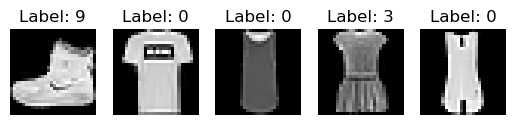

In [5]:
# Exibe as primeiras 5 imagens da base de treinamento
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_train_rbm[i].reshape(28, 28), cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')

plt.show()

# Aplicando Modelo RBM

In [6]:
from sklearn.neural_network import BernoulliRBM
rbm = BernoulliRBM(n_components=100, 
                   learning_rate=0.01, 
                   n_iter = 20, 
                   batch_size = 10,
                   random_state=0, 
                   verbose=True)
rbm.fit(x_train_rbm)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -251.58, time = 5.63s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -234.74, time = 6.23s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -224.05, time = 6.08s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -214.38, time = 6.03s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -209.79, time = 6.00s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -209.26, time = 6.20s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -206.55, time = 6.23s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -207.49, time = 6.23s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -203.89, time = 6.23s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -205.39, time = 6.26s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -201.51, time = 6.27s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -202.26, time = 6.32s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -199.80, time = 6.31s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -202.07, time = 6.39s
[BernoulliRBM] 

BernoulliRBM(learning_rate=0.01, n_components=100, n_iter=20, random_state=0,
             verbose=True)

In [7]:
print("Training set Pseudo-Likelihood =", rbm.score_samples(x_train_rbm).mean())
print("Validation set Pseudo-Likelihood =", rbm.score_samples(x_test_rbm).mean())

Training set Pseudo-Likelihood = -198.4027114181449
Validation set Pseudo-Likelihood = -201.3232480969709


### Reconstruindo a Base Teste

Referência: https://ml-lectures.org/docs/unsupervised_learning/Denoising.html

In [8]:
# Perform the denoising
k_iter = 50  # Number of Gibbs Sampling Iterations
alpha = 0.80  # Decay factor for the averaging

# Gibb sampling steps
b = rbm.gibbs(x_test_rbm)
x_final = np.zeros(784) + np.copy(b) # reconstroi uma matriz zerada do tamanho da base de Teste
for i in range(k_iter):
    b = rbm.gibbs(b)
    x_final += (alpha**(i+1))*b.astype(float) # Averaging the images

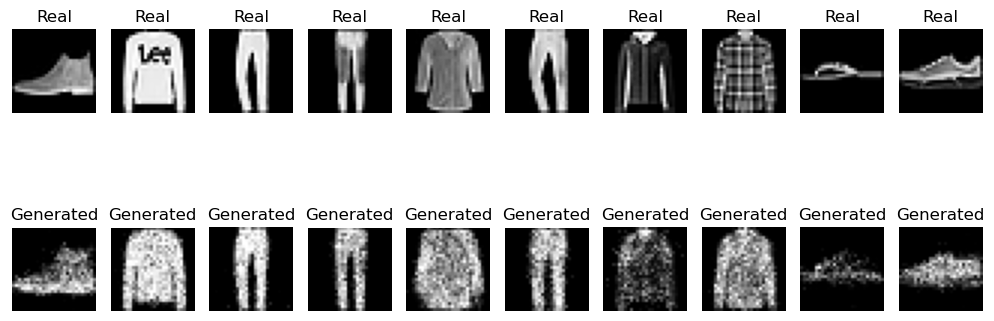

In [9]:
# Exibe as imagens reais da base de teste e as imagens geradas pelo RBM

num_generated_images = 10

plt.figure(figsize=(10, 5))
for i in range(num_generated_images):
    plt.subplot(2, num_generated_images, i + 1)
    plt.imshow(x_test_rbm[i].reshape(28, 28), cmap='gray')
    plt.title("Real")
    plt.axis('off')

    plt.subplot(2, num_generated_images, num_generated_images + i + 1)
    plt.imshow(x_final[i].reshape(28, 28), cmap='gray')
    plt.title("Generated")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Aplicando modelo Autoencoder

Código Exemplo do TensorFlow: https://www.tensorflow.org/tutorials/generative/autoencoder?hl=pt-br

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses

In [11]:
latent_dim = 100 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)

In [12]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [13]:
x_train_tf = x_train.astype('float32') / 255.
x_test_tf = x_test.astype('float32') / 255.

In [14]:
x_train_tf.shape, x_test_tf.shape

((60000, 28, 28), (10000, 28, 28))

In [15]:
autoencoder.fit(x_train_tf, x_train_tf,
                epochs=20,
                shuffle=True,
                validation_data=(x_test_tf, x_test_tf))

Epoch 1/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0211 - val_loss: 0.0115
Epoch 2/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0099 - val_loss: 0.0088
Epoch 3/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0082 - val_loss: 0.0079
Epoch 4/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0076 - val_loss: 0.0074
Epoch 5/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0072 - val_loss: 0.0072
Epoch 6/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0071 - val_loss: 0.0071
Epoch 7/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0069 - val_loss: 0.0070
Epoch 8/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0068 - val_loss: 0.0069
Epoch 9/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0067 - val_loss: 0.0068
Epoch 10/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.006

In [16]:
encoded_imgs = autoencoder.encoder(x_test_tf).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

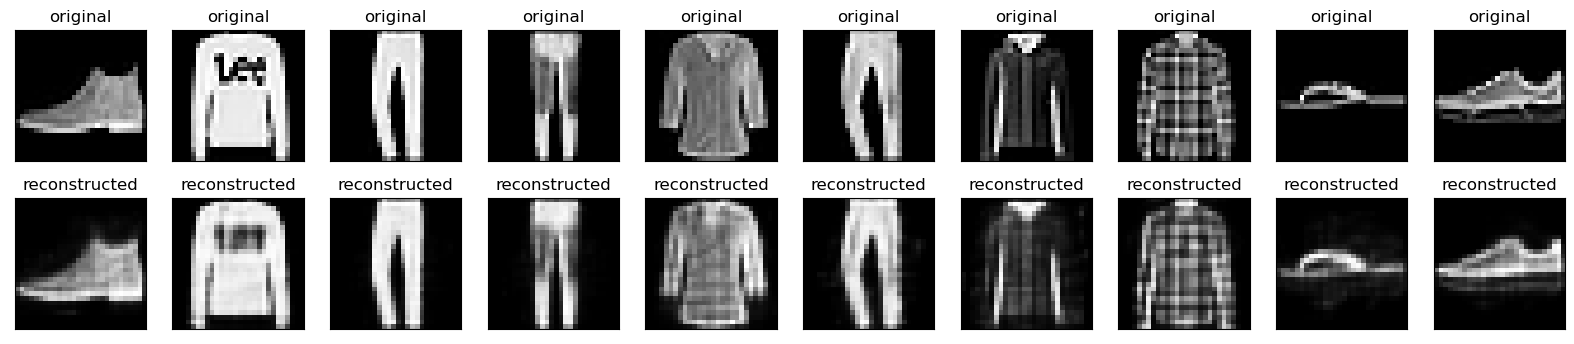

In [17]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()